## Train Mobilenet Classification on RGB+laser and laser-only data

In [13]:
import os
import torch
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
import tifffile
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import balanced_accuracy_score 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
ROOT_DIR = r"K:\ALL\coen\laser\exp1\output"

class_map = {
    "clean": 0,
    "soiled": 1
}

image_paths = []
labels = []

for class_name, label in class_map.items():
    class_dir = os.path.join(ROOT_DIR, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith((".tif", ".tiff")):
            image_paths.append(os.path.join(class_dir, fname))
            labels.append(label)

print(f"Total images: {len(image_paths)}")


Total images: 80


In [8]:
# Function to preprocess/denoise laser channels
def median_denoise(img, ksize=3):
    denoised = np.zeros_like(img)
    for c in range(img.shape[0]):
        denoised[c] = cv2.medianBlur(img[c], ksize)
    return denoised

def gaussian_smooth(img, ksize=(3,3), sigma=1.0):
    smoothed = np.zeros_like(img)
    for c in range(img.shape[0]):
        smoothed[c] = cv2.GaussianBlur(img[c], ksize, sigma)
    return smoothed

def clip_extremes(img, lower_percentile=0.1, upper_percentile=99.9):
    clipped = np.zeros_like(img)
    for c in range(img.shape[0]):
        low = np.percentile(img[c], lower_percentile)
        high = np.percentile(img[c], upper_percentile)
        clipped[c] = np.clip(img[c], low, high)
    return clipped

# Apply preprocessing to laser channels an calculate mean and std per channel for normalization
def calculate_mean_std(image_paths):
    processed_images = []

    for path in image_paths:
        img = tifffile.imread(path)        # shape (H, W, 5)
        img = np.transpose(img, (2, 0, 1)) # shape (5, H, W)

        # Apply preprocessing to laser channels only
        laser = img[3:].copy()
        laser = median_denoise(laser)
        laser = gaussian_smooth(laser)
        laser = clip_extremes(laser)

        img[3:] = laser 

        processed_images.append(img)

    all_imgs = np.stack(processed_images)  # shape (N, 5, H, W)
    mean = all_imgs.mean(axis=(0, 2, 3))
    std = all_imgs.std(axis=(0, 2, 3))
    return mean, std
    
mean, std = calculate_mean_std(image_paths)

print("Mean per channel:", mean)
print("Std per channel:", std)

Mean per channel: [1.02519463e+02 1.10820999e+02 1.19268295e+02 5.69955260e-02
 1.59645267e-02]
Std per channel: [4.5987179e+01 4.7344032e+01 4.8595116e+01 8.7896641e-03 2.8202157e-03]


## RGB + Laser

In [15]:
# Construct RGB+laser dataset
class LaserTiffDataset(Dataset):
    def __init__(self, image_paths, labels, mean, std, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.mean = mean[:, None, None]
        self.std = std[:, None, None]
        self.augment = augment

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = tifffile.imread(self.image_paths[idx])

        if img.shape[-1] == 5:
            img = np.transpose(img, (2, 0, 1))  # (5, H, W)
         
        # Preprocess laser channels (3 and 4)
        img = img.astype(np.float32)
       
        laser = img[3:].copy()  # shape (2, H, W)
        laser = median_denoise(laser, ksize=3)
        laser = gaussian_smooth(laser, ksize=(3,3), sigma=1.0)
        laser = clip_extremes(laser, lower_percentile=0.1, upper_percentile=99.9)
        img[3:] = laser  # replace laser channels with preprocessed ones
        
        img = torch.from_numpy(img).float()

        # Resize all channels to fixed size
        img = F.resize(img, (360, 360))
        
        # Apply augmentations
        if self.augment:
            img = self.apply_augmentations(img)

        # Normalize per channel
        img = (img - self.mean) / (self.std + 1e-6)

        label = torch.tensor(self.labels[idx]).long()
        return img, label

    def apply_augmentations(self, img):
        # img: torch.Tensor, shape (C, H, W)
    
        # Horizontal flip
        if torch.rand(1) < 0.5:
            img = torch.flip(img, dims=[2])  # flip width dimension
    
        # Rotation by 0°, 90°, 180°, 270°
        k = torch.randint(0, 4, (1,)).item()
        if k != 0:
            img = torch.rot90(img, k, dims=[1, 2])  # rotate along H,W axes
    
        return img

Fold 1


C:\Users\hrrcxh\AppData\Local\Temp\ipykernel_30092\2684808655.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = (img - self.mean) / (self.std + 1e-6)


Epoch [1/20], Loss: 1.2534
Epoch [2/20], Loss: 0.6168
Epoch [3/20], Loss: 0.5139
Epoch [4/20], Loss: 0.4054
Epoch [5/20], Loss: 0.3510
Epoch [6/20], Loss: 0.4951
Epoch [7/20], Loss: 0.3347
Epoch [8/20], Loss: 0.3491
Epoch [9/20], Loss: 0.1871
Epoch [10/20], Loss: 0.1622
Epoch [11/20], Loss: 0.1794
Epoch [12/20], Loss: 0.1820
Epoch [13/20], Loss: 0.3228
Epoch [14/20], Loss: 0.1541
Epoch [15/20], Loss: 0.2245
Epoch [16/20], Loss: 0.0976
Epoch [17/20], Loss: 0.3408
Epoch [18/20], Loss: 0.1555
Epoch [19/20], Loss: 0.1425
Epoch [20/20], Loss: 0.0293


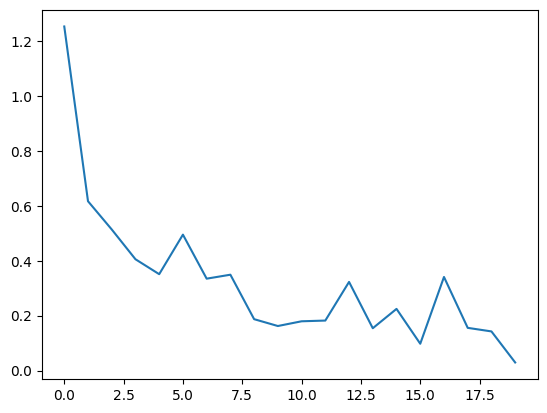

Prediction distribution (RGB+Laser): {1: 16}
Validation accuracy (RGB+Laser): 0.7500, balanced accuracy: 0.5000.
Fold 2


C:\Users\hrrcxh\AppData\Local\Temp\ipykernel_30092\2684808655.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = (img - self.mean) / (self.std + 1e-6)


Epoch [1/20], Loss: 1.3857
Epoch [2/20], Loss: 0.8396
Epoch [3/20], Loss: 0.6868
Epoch [4/20], Loss: 0.5580
Epoch [5/20], Loss: 0.4335
Epoch [6/20], Loss: 0.5679
Epoch [7/20], Loss: 0.3959
Epoch [8/20], Loss: 0.2687
Epoch [9/20], Loss: 0.1825
Epoch [10/20], Loss: 0.1818
Epoch [11/20], Loss: 0.2653
Epoch [12/20], Loss: 0.0706
Epoch [13/20], Loss: 0.1918
Epoch [14/20], Loss: 0.1491
Epoch [15/20], Loss: 0.2308
Epoch [16/20], Loss: 0.1353
Epoch [17/20], Loss: 0.1061
Epoch [18/20], Loss: 0.0438
Epoch [19/20], Loss: 0.1768
Epoch [20/20], Loss: 0.1921


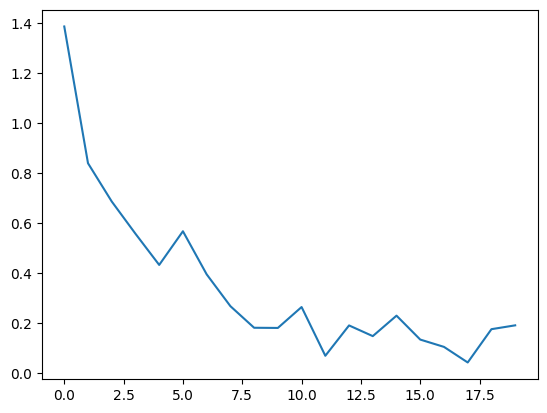

Prediction distribution (RGB+Laser): {0: 3, 1: 13}
Validation accuracy (RGB+Laser): 0.8125, balanced accuracy: 0.7083.
Fold 3


C:\Users\hrrcxh\AppData\Local\Temp\ipykernel_30092\2684808655.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = (img - self.mean) / (self.std + 1e-6)


Epoch [1/20], Loss: 0.9718
Epoch [2/20], Loss: 0.8609
Epoch [3/20], Loss: 0.6510
Epoch [4/20], Loss: 0.5170
Epoch [5/20], Loss: 0.5306
Epoch [6/20], Loss: 0.3977
Epoch [7/20], Loss: 0.4083
Epoch [8/20], Loss: 0.3639
Epoch [9/20], Loss: 0.4832
Epoch [10/20], Loss: 0.4943
Epoch [11/20], Loss: 0.3088
Epoch [12/20], Loss: 0.2143
Epoch [13/20], Loss: 0.1645
Epoch [14/20], Loss: 0.2434
Epoch [15/20], Loss: 0.3909
Epoch [16/20], Loss: 0.1668
Epoch [17/20], Loss: 0.1054
Epoch [18/20], Loss: 0.1291
Epoch [19/20], Loss: 0.0772
Epoch [20/20], Loss: 0.0700


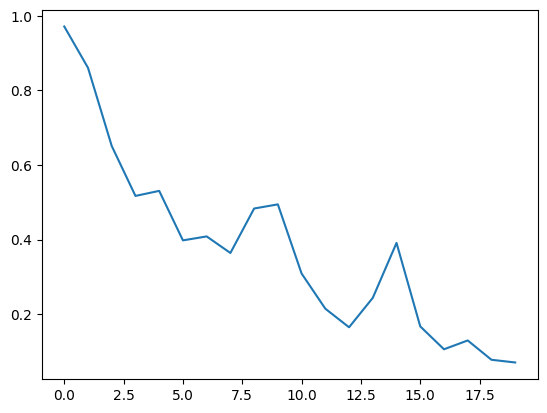

Prediction distribution (RGB+Laser): {0: 3, 1: 13}
Validation accuracy (RGB+Laser): 0.9375, balanced accuracy: 0.8750.
Fold 4


C:\Users\hrrcxh\AppData\Local\Temp\ipykernel_30092\2684808655.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = (img - self.mean) / (self.std + 1e-6)


Epoch [1/20], Loss: 0.8509
Epoch [2/20], Loss: 0.6706
Epoch [3/20], Loss: 0.6677
Epoch [4/20], Loss: 0.6155
Epoch [5/20], Loss: 0.6244
Epoch [6/20], Loss: 0.5095
Epoch [7/20], Loss: 0.4643
Epoch [8/20], Loss: 0.2820
Epoch [9/20], Loss: 0.3053
Epoch [10/20], Loss: 0.2052
Epoch [11/20], Loss: 0.1590
Epoch [12/20], Loss: 0.2326
Epoch [13/20], Loss: 0.1540
Epoch [14/20], Loss: 0.2333
Epoch [15/20], Loss: 0.1978
Epoch [16/20], Loss: 0.1138
Epoch [17/20], Loss: 0.0512
Epoch [18/20], Loss: 0.0163
Epoch [19/20], Loss: 0.0903
Epoch [20/20], Loss: 0.2408


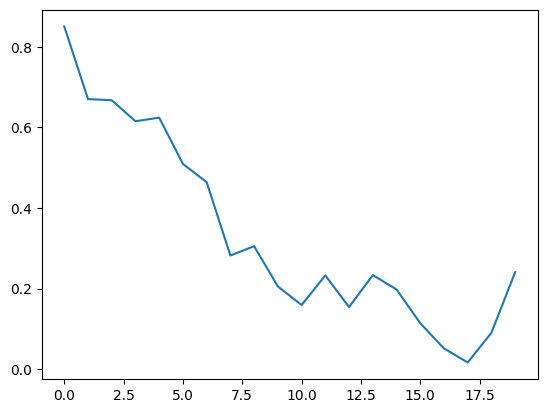

Prediction distribution (RGB+Laser): {0: 1, 1: 15}
Validation accuracy (RGB+Laser): 0.8125, balanced accuracy: 0.6250.
Fold 5


C:\Users\hrrcxh\AppData\Local\Temp\ipykernel_30092\2684808655.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = (img - self.mean) / (self.std + 1e-6)


Epoch [1/20], Loss: 0.9569
Epoch [2/20], Loss: 0.8685
Epoch [3/20], Loss: 0.7206
Epoch [4/20], Loss: 0.5430
Epoch [5/20], Loss: 0.4383
Epoch [6/20], Loss: 0.4054
Epoch [7/20], Loss: 0.3976
Epoch [8/20], Loss: 0.3380
Epoch [9/20], Loss: 0.2625
Epoch [10/20], Loss: 0.3269
Epoch [11/20], Loss: 0.3147
Epoch [12/20], Loss: 0.1586
Epoch [13/20], Loss: 0.2416
Epoch [14/20], Loss: 0.1314
Epoch [15/20], Loss: 0.1367
Epoch [16/20], Loss: 0.1230
Epoch [17/20], Loss: 0.1954
Epoch [18/20], Loss: 0.0498
Epoch [19/20], Loss: 0.1024
Epoch [20/20], Loss: 0.0781


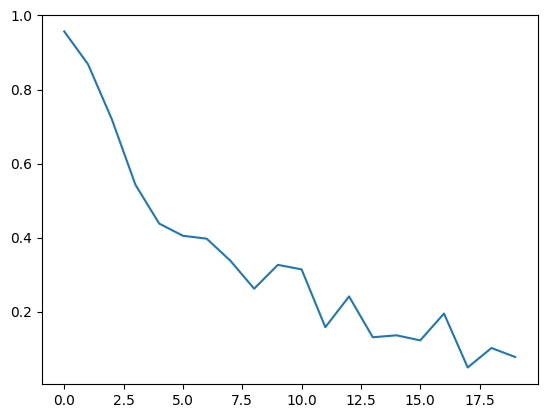

Prediction distribution (RGB+Laser): {0: 1, 1: 15}
Validation accuracy (RGB+Laser): 0.8125, balanced accuracy: 0.6250.
Mean accuracy with laser: 0.825 +- 0.06846531968814577.
Mean balanced accuracy with laser: 0.6666666666666666 +- 0.13819269959814165.
Confusion Matrix: 
[[0.35       0.65      ]
 [0.01666667 0.98333333]]


In [16]:
# Perform 5-fold cross-validation of Mobilenet classification with RGB + laser data
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_list = []
bal_acc_list = []

y_true_all = []
y_pred_all = []

for fold, (train_idx, val_idx) in enumerate(kf.split(image_paths, labels)):
    print(f"Fold {fold+1}")

    # Create train/test split 
    train_paths_fold = [image_paths[i] for i in train_idx]
    train_labels_fold = [labels[i] for i in train_idx]
    val_paths_fold = [image_paths[i] for i in val_idx]
    val_labels_fold = [labels[i] for i in val_idx]

    train_dataset = LaserTiffDataset(train_paths_fold, train_labels_fold, mean, std, augment=True)
    val_dataset = LaserTiffDataset(val_paths_fold, val_labels_fold, mean, std, augment=False)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

    # Load model
    num_classes = 2
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Load pretrained MobileNetV3
    model = models.mobilenet_v3_small(weights="IMAGENET1K_V1") # "IMAGENET1K_V1"
    
    # Modify first conv for 5-channel input
    old_conv = model.features[0][0]
    
    model.features[0][0] = nn.Conv2d(
        in_channels=5,
        out_channels=old_conv.out_channels,
        kernel_size=old_conv.kernel_size,
        stride=old_conv.stride,
        padding=old_conv.padding,
        bias=False
    )

    # Initialize new channels, ImageNet weights for RGB, mean of RGB for laser channels
    with torch.no_grad():
        model.features[0][0].weight[:, :3] = old_conv.weight
        model.features[0][0].weight[:, 3:] = old_conv.weight.mean(dim=1, keepdim=True)
        
    # Modify classifier for binary classification
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, num_classes)
    
    model = model.to(device)

    # Use weighted loss fucntion to adress class imbalance
    weights = torch.tensor([60/20, 1.0], dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

    # Train model for this fold
    num_epochs = 20
    ep_list = []
    for epoch in range(num_epochs):       
        model.train()
        running_loss = 0
    
        for imgs, train_labels in train_loader:
            imgs, train_labels = imgs.to(device), train_labels.to(device)
    
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, train_labels)
            loss.backward()

            optimizer.step()
    
            running_loss += loss.item() * imgs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        ep_list.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    plt.figure()
    plt.plot(ep_list)
    plt.show()

    # Evaluate on validation data
    model.eval()
    
    all_preds = []
    all_labels = []
        
    with torch.no_grad():
        for imgs, val_labels in val_loader:
            imgs = imgs.to(device)
            val_labels = val_labels.to(device)

            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
    
            all_preds.append(preds.cpu())
            all_labels.append(val_labels.cpu())
    
    # Concatenate
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    # Prediction distributions to check for class collapse
    unique, counts = torch.unique(all_preds, return_counts=True)
    print("Prediction distribution (RGB+Laser):",
          dict(zip(unique.tolist(), counts.tolist())))

    # Accuracies
    acc = (all_preds == all_labels).float().mean().item()

    
    # Save ground truths and predictions for confusion matrix
    y_true = all_labels.cpu().numpy()
    y_pred = all_preds.cpu().numpy()

    y_true_all.append(y_true)
    y_pred_all.append(y_pred)

    # Calculate balanced accuracy
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    
    accuracy_list.append(acc)
    bal_acc_list.append(bal_acc)      
    
    print(f"Validation accuracy (RGB+Laser): {acc:.4f}, balanced accuracy: {bal_acc:.4f}.")

# Calculate mean accuracy
mean_acc = sum(accuracy_list)/len(accuracy_list)
std_acc = np.std(accuracy_list, ddof=1)

# Calculate mean balanced accuracy
mean_bal_acc = sum(bal_acc_list)/len(bal_acc_list)
std_bal_acc = np.std(bal_acc_list, ddof=1)

# Compute confusion matrix
y_true_conc = np.concatenate(y_true_all)
y_pred_conc = np.concatenate(y_pred_all)

cm = confusion_matrix(y_true_conc, y_pred_conc, labels=np.array([0,1]), normalize='true')

print(f"Mean accuracy RGB+laser: {mean_acc} +- {std_acc}.")
print(f"Mean balanced accuracy RGB+laser: {mean_bal_acc} +- {std_bal_acc}.")
print(f"Confusion Matrix: \n{cm}")

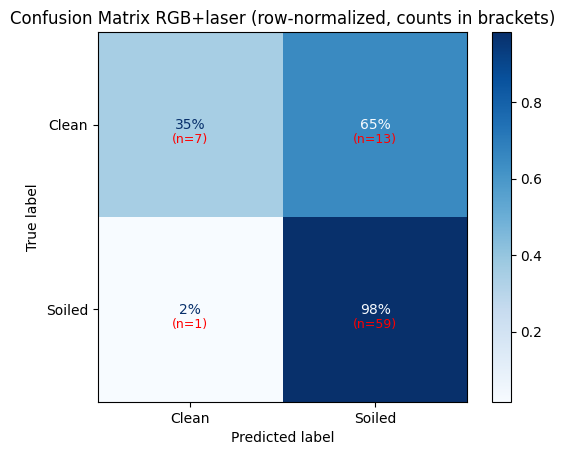

In [22]:
# Compute and visualize row-normalized confusion matrix with counts in brackets
cm_counts = confusion_matrix(y_true_conc, y_pred_conc, labels=[0, 1])
cm_norm = confusion_matrix(y_true_conc, y_pred_conc, labels=[0, 1], normalize="true")

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_norm,
    display_labels=["Clean", "Soiled"]
)

ax = disp.plot(cmap="Blues", values_format=".0%").ax_

for i in range(2):
    for j in range(2):
        ax.text(
            j, i,
            f"\n\n(n={cm_counts[i, j]})",
            ha="center", va="center", fontsize=9, color="red"
        )

plt.title("Confusion Matrix RGB+laser (row-normalized, counts in brackets)")
plt.show()

## RGB-only

In [23]:
# Create RGB-only dataset
rgb_mean = mean[:3]
rgb_std = std[:3]

class RGBDataset(Dataset):
    def __init__(self, image_paths, labels, mean, std, augment = False):
        self.image_paths = image_paths
        self.labels = labels
        self.mean = mean[:, None, None]
        self.std = std[:, None, None]
        self.augment = augment

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = tifffile.imread(self.image_paths[idx])

        if img.shape[-1] == 5:
            img = img[:, :, :3]  # Take only first 3 channels (RGB)
            
        img = np.transpose(img, (2, 0, 1))  # (5, H, W)

        img = torch.from_numpy(img).float()

        # Resize all channels to fixed size
        img = F.resize(img, (360, 360))
        
        # Apply augmentations
        if self.augment:
            img = self.apply_augmentations(img)

        # Normalize per channel
        img = (img - self.mean) / (self.std + 1e-6)

        label = torch.tensor(self.labels[idx]).long()
        return img, label

    def apply_augmentations(self, img):
        # img: torch.Tensor, shape (C, H, W)
    
        # Horizontal flip
        if torch.rand(1) < 0.5:
            img = torch.flip(img, dims=[2])  # flip width dimension
    
        # Rotation by 0°, 90°, 180°, 270°
        k = torch.randint(0, 4, (1,)).item()
        if k != 0:
            img = torch.rot90(img, k, dims=[1, 2])  # rotate along H,W axes
    
        return img

Fold 1


C:\Users\hrrcxh\AppData\Local\Temp\ipykernel_30092\3697989899.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = (img - self.mean) / (self.std + 1e-6)


Epoch [1/20], Loss: 0.7984
Epoch [2/20], Loss: 0.5374
Epoch [3/20], Loss: 0.3044
Epoch [4/20], Loss: 0.2018
Epoch [5/20], Loss: 0.0968
Epoch [6/20], Loss: 0.1093
Epoch [7/20], Loss: 0.0461
Epoch [8/20], Loss: 0.0649
Epoch [9/20], Loss: 0.1252
Epoch [10/20], Loss: 0.0785
Epoch [11/20], Loss: 0.0745
Epoch [12/20], Loss: 0.0370
Epoch [13/20], Loss: 0.0151
Epoch [14/20], Loss: 0.0033
Epoch [15/20], Loss: 0.0166
Epoch [16/20], Loss: 0.0083
Epoch [17/20], Loss: 0.0870
Epoch [18/20], Loss: 0.4176
Epoch [19/20], Loss: 0.0784
Epoch [20/20], Loss: 0.0309


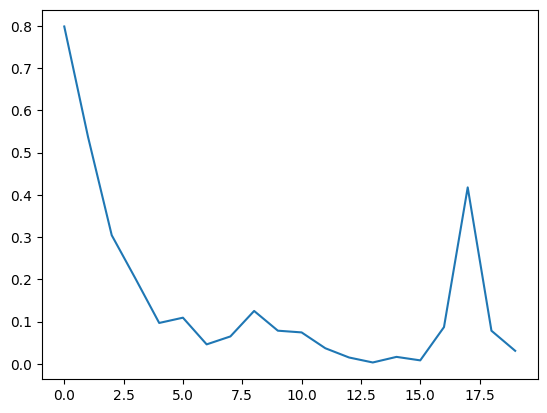

Prediction distribution (RGB+Laser): {0: 1, 1: 15}
Validation accuracy (RGB-only): 0.8125, balanced accuracy: 0.6250.
Fold 2


C:\Users\hrrcxh\AppData\Local\Temp\ipykernel_30092\3697989899.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = (img - self.mean) / (self.std + 1e-6)


Epoch [1/20], Loss: 0.8147
Epoch [2/20], Loss: 0.5756
Epoch [3/20], Loss: 0.3583
Epoch [4/20], Loss: 0.2331
Epoch [5/20], Loss: 0.2256
Epoch [6/20], Loss: 0.1520
Epoch [7/20], Loss: 0.0893
Epoch [8/20], Loss: 0.0292
Epoch [9/20], Loss: 0.1299
Epoch [10/20], Loss: 0.1369
Epoch [11/20], Loss: 0.0717
Epoch [12/20], Loss: 0.0430
Epoch [13/20], Loss: 0.0358
Epoch [14/20], Loss: 0.0219
Epoch [15/20], Loss: 0.0576
Epoch [16/20], Loss: 0.0234
Epoch [17/20], Loss: 0.0404
Epoch [18/20], Loss: 0.0236
Epoch [19/20], Loss: 0.0055
Epoch [20/20], Loss: 0.0034


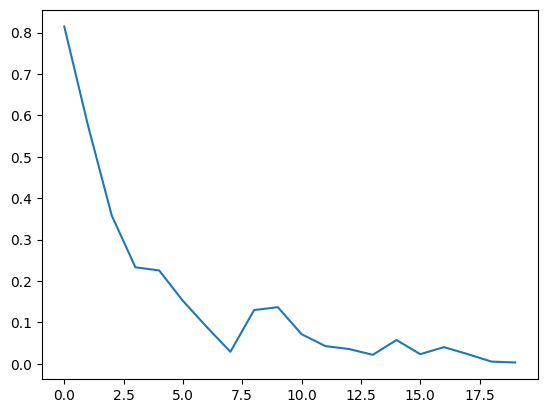

Prediction distribution (RGB+Laser): {0: 5, 1: 11}
Validation accuracy (RGB-only): 0.8125, balanced accuracy: 0.7917.
Fold 3


C:\Users\hrrcxh\AppData\Local\Temp\ipykernel_30092\3697989899.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = (img - self.mean) / (self.std + 1e-6)


Epoch [1/20], Loss: 0.8037
Epoch [2/20], Loss: 0.6397
Epoch [3/20], Loss: 0.5286
Epoch [4/20], Loss: 0.3551
Epoch [5/20], Loss: 0.2441
Epoch [6/20], Loss: 0.2622
Epoch [7/20], Loss: 0.1077
Epoch [8/20], Loss: 0.0607
Epoch [9/20], Loss: 0.1803
Epoch [10/20], Loss: 0.1210
Epoch [11/20], Loss: 0.0721
Epoch [12/20], Loss: 0.0366
Epoch [13/20], Loss: 0.0115
Epoch [14/20], Loss: 0.0221
Epoch [15/20], Loss: 0.0065
Epoch [16/20], Loss: 0.0069
Epoch [17/20], Loss: 0.0139
Epoch [18/20], Loss: 0.0293
Epoch [19/20], Loss: 0.0012
Epoch [20/20], Loss: 0.1582


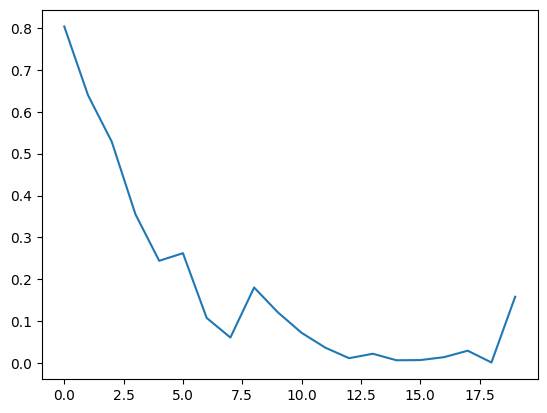

Prediction distribution (RGB+Laser): {0: 1, 1: 15}
Validation accuracy (RGB-only): 0.6875, balanced accuracy: 0.4583.
Fold 4


C:\Users\hrrcxh\AppData\Local\Temp\ipykernel_30092\3697989899.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = (img - self.mean) / (self.std + 1e-6)


Epoch [1/20], Loss: 0.8894
Epoch [2/20], Loss: 0.6719
Epoch [3/20], Loss: 0.5110
Epoch [4/20], Loss: 0.3452
Epoch [5/20], Loss: 0.4050
Epoch [6/20], Loss: 0.1774
Epoch [7/20], Loss: 0.1374
Epoch [8/20], Loss: 0.1764
Epoch [9/20], Loss: 0.0898
Epoch [10/20], Loss: 0.0657
Epoch [11/20], Loss: 0.0184
Epoch [12/20], Loss: 0.0886
Epoch [13/20], Loss: 0.1140
Epoch [14/20], Loss: 0.0818
Epoch [15/20], Loss: 0.0927
Epoch [16/20], Loss: 0.0217
Epoch [17/20], Loss: 0.0353
Epoch [18/20], Loss: 0.0288
Epoch [19/20], Loss: 0.0160
Epoch [20/20], Loss: 0.0977


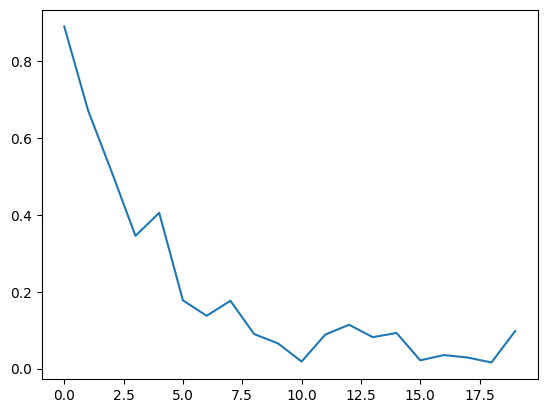

Prediction distribution (RGB+Laser): {0: 4, 1: 12}
Validation accuracy (RGB-only): 1.0000, balanced accuracy: 1.0000.
Fold 5


C:\Users\hrrcxh\AppData\Local\Temp\ipykernel_30092\3697989899.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = (img - self.mean) / (self.std + 1e-6)


Epoch [1/20], Loss: 0.8184
Epoch [2/20], Loss: 0.6883
Epoch [3/20], Loss: 0.4339
Epoch [4/20], Loss: 0.2161
Epoch [5/20], Loss: 0.2300
Epoch [6/20], Loss: 0.0989
Epoch [7/20], Loss: 0.1601
Epoch [8/20], Loss: 0.1057
Epoch [9/20], Loss: 0.1510
Epoch [10/20], Loss: 0.0563
Epoch [11/20], Loss: 0.0746
Epoch [12/20], Loss: 0.0486
Epoch [13/20], Loss: 0.0089
Epoch [14/20], Loss: 0.0139
Epoch [15/20], Loss: 0.0024
Epoch [16/20], Loss: 0.0050
Epoch [17/20], Loss: 0.0013
Epoch [18/20], Loss: 0.0026
Epoch [19/20], Loss: 0.0015
Epoch [20/20], Loss: 0.0014


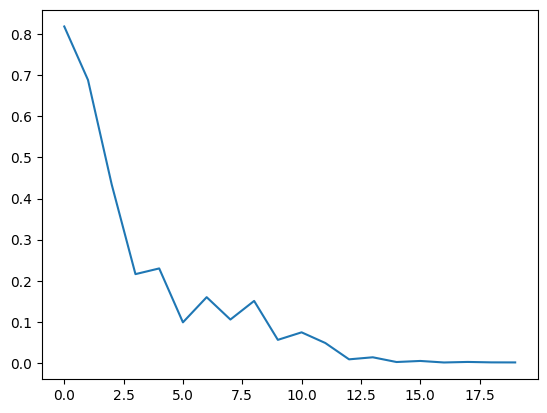

Prediction distribution (RGB+Laser): {0: 5, 1: 11}
Validation accuracy (RGB-only): 0.6875, balanced accuracy: 0.6250.
Mean accuracy RGB-only: 0.8 +- 0.128086884574495.
Mean balanced accuracy RGB-only: 0.7 +- 0.20497289793748072.
Confusion Matrix: 
[[0.5 0.5]
 [0.1 0.9]]


In [24]:
# Perform 5-fold cross-validation of Mobilenet classification with RGB-only data
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_list = []
bal_acc_list = []

y_true_all = []
y_pred_all = []

for fold, (train_idx, val_idx) in enumerate(kf.split(image_paths, labels)):
    print(f"Fold {fold+1}")

    # Create train/test splits
    train_paths_fold = [image_paths[i] for i in train_idx]
    train_labels_fold = [labels[i] for i in train_idx]
    val_paths_fold = [image_paths[i] for i in val_idx]
    val_labels_fold = [labels[i] for i in val_idx]

    train_dataset = RGBDataset(train_paths_fold, train_labels_fold, rgb_mean, rgb_std)
    val_dataset = RGBDataset(val_paths_fold, val_labels_fold, rgb_mean, rgb_std)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

    # load model
    num_classes = 2
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Load pretrained MobileNetV3
    model = models.mobilenet_v3_small(weights="IMAGENET1K_V1") # "IMAGENET1K_V1"

    # Replace classifier
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, num_classes)
    
    model = model.to(device)

    # Weighted loss function to adress class imbalance
    weights = torch.tensor([60/20, 1.0], dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

    # Train model for this fold
    num_epochs = 20
    ep_list = []
    
    for epoch in range(num_epochs):          
        model.train()
        running_loss = 0
    
        for imgs, train_labels in train_loader:
            imgs, train_labels = imgs.to(device), train_labels.to(device)
    
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item() * imgs.size(0)
    
        epoch_loss = running_loss / len(train_loader.dataset)
        ep_list.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
    plt.figure()
    plt.plot(ep_list)
    plt.show()
    
    # Evaluate on validation data
    model.eval()

    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, val_labels in val_loader:
            imgs, val_labels = imgs.to(device), val_labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(val_labels.cpu())

    # Concatenate
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    # Prediction distributions
    unique, counts = torch.unique(all_preds, return_counts=True)
    print("Prediction distribution (RGB+Laser):",
          dict(zip(unique.tolist(), counts.tolist())))

    # Accuracies
    acc = (all_preds == all_labels).float().mean().item()

    
    # Data for confusion matrix
    y_true = all_labels.cpu().numpy()
    y_pred = all_preds.cpu().numpy()

    y_true_all.append(y_true)
    y_pred_all.append(y_pred)

    # Balanced accuracy
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    
    accuracy_list.append(acc)
    bal_acc_list.append(bal_acc)
                        
    print(f"Validation accuracy (RGB-only): {acc:.4f}, balanced accuracy: {bal_acc:.4f}.")

mean_acc = sum(accuracy_list)/len(accuracy_list)
std_acc = np.std(accuracy_list, ddof=1)

mean_bal_acc = sum(bal_acc_list)/len(bal_acc_list)
std_bal_acc = np.std(bal_acc_list, ddof=1)

y_true_conc = np.concatenate(y_true_all)
y_pred_conc = np.concatenate(y_pred_all)

cm = confusion_matrix(y_true_conc, y_pred_conc, labels=np.array([0,1]), normalize='true')

print(f"Mean accuracy RGB-only: {mean_acc} +- {std_acc}.")
print(f"Mean balanced accuracy RGB-only: {mean_bal_acc} +- {std_bal_acc}.")
print(f"Confusion Matrix: \n{cm}")

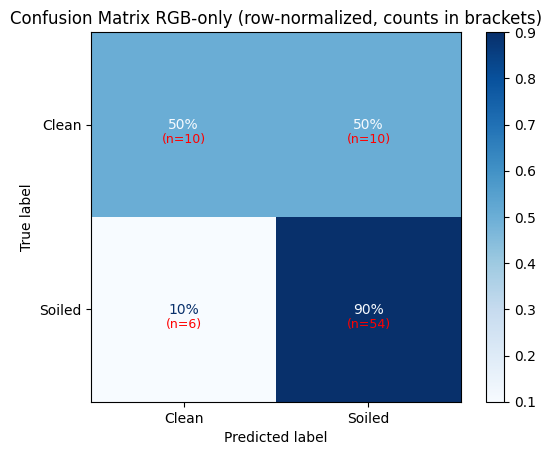

In [26]:
# Compute and visualize row-normalized confusion matrix with counts in brackets
cm_counts = confusion_matrix(y_true_conc, y_pred_conc, labels=[0, 1])
cm_norm = confusion_matrix(y_true_conc, y_pred_conc, labels=[0, 1], normalize="true")

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_norm,
    display_labels=["Clean", "Soiled"]
)

ax = disp.plot(cmap="Blues", values_format=".0%").ax_

for i in range(2):
    for j in range(2):
        ax.text(
            j, i,
            f"\n\n(n={cm_counts[i, j]})",
            ha="center", va="center", fontsize=9, color="red"
        )

plt.title("Confusion Matrix RGB-only (row-normalized, counts in brackets)")
plt.show()